### 概述
关于单资产的策略，是有一套固定的框架来进行研究的，该notebook用于实现这样一套框架，
以提高策略的研究效率。 大体来说，该研究框架建立在显著性会在一段时间内持续下去这样的
假设上。比如如果我们统计过去一年内，上一日的日间回报与下一日的日内回报存在显著的正相关性，
则可以认为未来一段时间内这种相关性仍然存在。之所以使用这样的假设，是因为受到样本大小的限制，
在任一时间横截面上，都只能有一个样本数据，基于这样一个样本的数据，是无法找到统计规律的，
所以我们只能将时间横截面扩展到一个足够的时间区间中，并且假设这个时间区间内这个关系是稳定的。

在这样的假设下，使用高频的数据是有优势的，因为能够在较短的时间区间内累积到足够的样本数，从
而发现显著的关系。

使用不同类型或者不同粒度的时序数据，研究方法是不一样的，时序类型以及时间粒度其实决定
的是可交易的时刻，可交易时刻必须是能够确定价格的时刻，比如若使用日bar的时序数据，则
可交易时刻是每天的开盘和收盘。若使用分钟bar的时序数据，则可交易时刻是交易时间段内所有分钟
的开始（或结束）。 更细粒度的时序类型就暂时不考虑了，因为数据量太大，可能会带来一些性能
问题。确定了交易时间点后，就可以在任意的时间点来找过去回报和未来回报之间的相关性（这背后
的假设是有很多的时间点都具有相同的相关性，比如每天的开盘时刻都有相同的关系、每个周五的收盘
都有相同的关系、每分钟的开始都有相同的关系）。这个相关性可以是线性的，通过相关系数来衡量，
或者是非线性的，使用分类统计值衡量。

使用分钟bar的时序类型的研究是比较简单的，可以在每个分钟开始尝试过去p分钟的回报跟未来q分钟回报
的相关性。可以每天的数据进行分开统计，不可能每天的相关性都是显著的，可能只有少数的天数是显著
的，假设显著性的标准是p=0.05,M天的统计区间内有N天是显著的，则可以计算事件：M天内有大于等于N
天发生事件e的概率，事件e的发生概率是0.05。这背后的假设是若显著性是偶然发生的，则发生概率是0.05,
在M次独立重复实验中至少发生N次的概率是是可以计算出来的，如果这个概率是小概率，则可以拒绝背后的假设。
这背后的假设检验逻辑是：H0 不存在相关性， H1 存在相关性，在原假设为真的情况下，可以得到事件（显著相关性）发生k次的概率分布，
从而可以得到拒绝域。之所以选用大于等于这个事件作为评价标准，是因为大于等于描述的就是拒绝域，我们可以通过
p值计算出拒绝域，也可以通过具体的临界值（如大于等于4）来计算p值，这两种方式都可以用来拒绝H0假设，是等价的。

In [1]:
from se2.domain.time_series import *
from se2.domain.engine import *
from se2.domain.account import *
from se2.domain.common import *
import pandas as pd
import numpy as np

ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:hfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:hfarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:usfuture
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:usfuture
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:jfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:jfarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:eufarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:eufarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:cashfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:cashfarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:usfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:usfarm
ERROR:ibapi.wrapper:ERROR -1 2106 历史市场数据农场连接正常:euhmds
ERROR:root:ib client error, req_id:-1, errorCode:2106, errorString:历史市场数据农场连接正常:euhmds
ERROR:ibapi.wrapper:ERROR -1 2106

In [2]:
import scipy.stats

In [3]:
code = 'SPCE_STK_USD_SMART'
start = pd.Timestamp('2021-01-09 21:00:00', tz='Asia/Shanghai')
end = pd.Timestamp('2021-06-09 21:00:00', tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, [code])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)

In [11]:
# 加载最近一个月的数据
ts: TimeSeries = ts_repo.find_one("ibMinBar")
MIN_BAR_DF: DataFrame = ts.history_data(command, from_local=True)
MIN_BAR_DF = MIN_BAR_DF.droplevel(level=1)
MIN_BAR_DF.head()

,start_time,open,high,low,close,volume
visible_time,,,,,,
2021-01-11 22:31:00+08:00,2021-01-11 22:30:00+08:00,24.97,24.99,24.85,24.86,2193
2021-01-11 22:32:00+08:00,2021-01-11 22:31:00+08:00,24.85,25.14,24.81,25.06,484
2021-01-11 22:33:00+08:00,2021-01-11 22:32:00+08:00,25.09,25.17,24.85,24.91,539
2021-01-11 22:34:00+08:00,2021-01-11 22:33:00+08:00,24.97,25.00,24.80,24.85,691
2021-01-11 22:35:00+08:00,2021-01-11 22:34:00+08:00,24.83,24.96,24.77,24.79,359


In [198]:
# 按天计算相关系数，计算相关系数的时候使用重叠的数据，真实交易的过程
# 只是这个样本数据的一个子集
P = 10
def calc(df: DataFrame):
    if len(df) <= 0:
        return None
    # def calc_min_ret(sdf: DataFrame):
    #     return np.log(sdf.iloc[-1] / sdf.iloc[0])
    #
    # p_min_rets = df['close'].groupby(pd.Grouper(freq='{}Min'.format(P), origin='start')).apply(calc_min_ret)
    # dd = pd.DataFrame({'r1': p_min_rets, 'r2': p_min_rets.shift(-1)}).dropna()
    #
    ret1 = np.log(df['close'] / df['close'].shift(P))
    ret2 = np.log(df['close'].shift(-P) / df['close'])
    #
    dd = pd.DataFrame({'r1': ret1, 'r2': ret2}).dropna()
    r, p = scipy.stats.spearmanr(dd.values[:, 0], dd.values[:, 1])
    return pd.Series({"r": r, 'p': p})


res = data.groupby(pd.Grouper(freq='1D', origin='start')).apply(calc).dropna()
from prop import min_happen_prop
print("显著正相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]>0)]),len(res)))
print("显著负相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]<0)]), len(res)))
print(min_happen_prop(len(res), len(res[(res['p']<0.05) & (res["r"]<0)]), 0.05))


显著正相关数：3/21
显著负相关数：7/21
4.87135732627759e-05


In [290]:
# 计算回报
# 回测跟研究是不同的， 假设使用10分钟的bar数据进行预测未来十分钟的回报的话，则交易间隔至少是10分钟，
# 这也意味着如果进行了交易决策，后续十分钟内的交易信号就必须忽略掉（这种属于基于时间的退出策略，即退出
# 决策只依赖时间，而不依赖价格的变化）。
# 这种逻辑使用DataFrame似乎不好计算，
P = 10
def calc_daily_ret(df: DataFrame):
    if len(df) <= 0:
        return
    p_min_rets = np.log(df['close'] / df['close'].shift(P))
    rets: DataFrame = pd.DataFrame({'pre_ret': p_min_rets, "next_ret": p_min_rets.shift(-P)})
    rets = rets.dropna()
    up_threshold = 0
    down_threshold = -0
    trade_count = 0
    total_ret = 0
    interval_count = P
    for dt, s in rets.iterrows():
        interval_count += P+1
        if s['pre_ret'] > up_threshold and interval_count > P:
            total_ret += -s['next_ret']
            interval_count = 0
            trade_count += 1
        elif s['pre_ret'] < down_threshold and interval_count > P:
            total_ret += s['next_ret']
            interval_count = 0
            trade_count += 1

    return pd.Series({"ret":total_ret, "trade_count": trade_count})


st_daily_ret = data.groupby(pd.Grouper(freq='1D', origin='start')).apply(calc_daily_ret).dropna()
total_ret = np.exp(st_daily_ret['ret'].sum()) - 1
print("总回报:{}".format(total_ret))

总回报:0.07346240246482916


In [291]:
st_daily_ret

,ret,trade_count
visible_time,,
2021-04-09 21:31:00+08:00,0.184457,350.0
2021-04-12 21:31:00+08:00,-0.063464,349.0
2021-04-13 21:31:00+08:00,0.165177,351.0
2021-04-14 21:31:00+08:00,-0.194931,361.0
2021-04-15 21:31:00+08:00,-0.121803,357.0
2021-04-16 21:31:00+08:00,0.199951,351.0
2021-04-19 21:31:00+08:00,-0.156595,350.0
2021-04-20 21:31:00+08:00,0.299408,353.0
2021-04-21 21:31:00+08:00,0.137278,359.0


In [105]:
# 从总体上来说，过去十分钟和未来十分钟存在负相关，但是因为你不可能在每一分钟进行
# 下注，因为每次你的持续时间都是十分钟，所以你只能选择那些绝对好的机会进行下注，
# 比如下跌超过一定阀值时，或者上涨超过一定阀值时
P = 5
daily_df = data.loc[:'2021-04-10 21:00:00']
rets = np.log(daily_df['close'] / daily_df['close'].shift(P))
rets.describe()

count    380.000000
mean       0.000220
std        0.003256
min       -0.009920
25%       -0.002051
50%        0.000000
75%        0.002393
max        0.009606
Name: close, dtype: float64

In [109]:
dd = pd.DataFrame({"pre_ret": rets, 'after_ret': rets.shift(-P)})
dd = dd.dropna()


In [118]:
dd[dd['pre_ret']<-0.005]['after_ret']

visible_time
2021-04-09 22:05:00+08:00    0.003779
2021-04-09 22:06:00+08:00    0.006521
2021-04-09 22:07:00+08:00    0.009596
2021-04-09 22:28:00+08:00    0.001715
2021-04-09 22:29:00+08:00    0.003774
2021-04-09 22:30:00+08:00   -0.001372
2021-04-09 22:31:00+08:00    0.000343
2021-04-09 22:32:00+08:00   -0.002745
2021-04-10 00:40:00+08:00   -0.001029
2021-04-10 01:15:00+08:00    0.000686
2021-04-10 01:16:00+08:00    0.001029
2021-04-10 01:17:00+08:00    0.000343
2021-04-10 01:39:00+08:00    0.001035
2021-04-10 03:41:00+08:00    0.001714
2021-04-10 03:42:00+08:00    0.001714
2021-04-10 03:43:00+08:00    0.002399
2021-04-10 03:45:00+08:00    0.002057
Name: after_ret, dtype: float64

In [117]:
dd[dd['pre_ret']>0.005]['after_ret'].describe()

count    34.000000
mean     -0.002850
std       0.003488
min      -0.009920
25%      -0.005134
50%      -0.003244
75%      -0.000342
max       0.005127
Name: after_ret, dtype: float64

In [244]:
test_data = data.loc[:'2021-04-10 21:00:00']
rets = np.log(test_data['close'] / test_data['close'].shift(10))
after_rets = rets.shift(-10)

df = pd.DataFrame({'pre_ret': rets, 'after_ret': after_rets}).dropna()
total_ret = 0
for dt, s in df.iloc[::10].iterrows():
    if s['pre_ret'] > 0:
        total_ret += -s['after_ret']
    elif s['pre_ret'] < 0:
        total_ret += s['after_ret']
print(total_ret)

KeyboardInterrupt: 

<AxesSubplot:xlabel='pre_ret', ylabel='after_ret'>

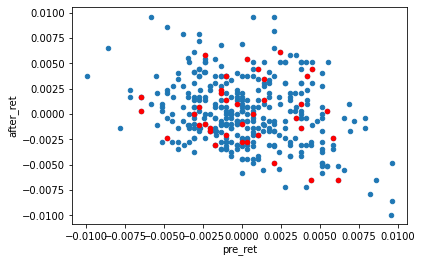

In [230]:
ax = df.plot.scatter('pre_ret', 'after_ret')
df.iloc[::10].plot.scatter('pre_ret', 'after_ret',color='red', ax=ax)

In [ ]:
# 如果不考虑重叠样本数据影响的话，我确实在各个分钟粒度上都发现了相邻回报的负相关性
# 这似乎是也预示着股价存在回归现象，但是回测的时候却不能带来稳定的回报，这两者之间
# 唯一的区别就是研究的时候使用的样本数据有重叠，
# 当研究10分钟的bar时，如果使用重叠数据，可以得到370个样本，如果使用非重叠的数据，
# 则只能得到37个样本，这就导致了虽然从370个样本中能够观察到相关性，但是在37个样本中看不到
# 这种相关性。
# 而且使用重叠数据，背离了独立重复实验的的前提，即实验与实验之间的独立性，样本数据之间有很强
# 的相关性，所以从这些互相具有强相关性的样本数据得到的统计显著性可能并不显著。所以下面研究
# 相关性的时候，不使用重叠数据。


In [27]:
# 计算不同分钟时间粒度的回报的一阶相关性，计算过程中，要避免使用重复的样本数据
# 每天的数据分开进行计算
P = 1
def calc(df: DataFrame):
    if len(df) <= 0:
        return None
    # 最近p分钟的回报
    ret: Series = np.log(df['close'] / df['close'].shift(P))
    # 下一个p分钟的回报
    next_ret = ret.shift(-P)
    rets: DataFrame = pd.DataFrame({'pre_ret': ret, "next_ret": next_ret}).dropna()
    # 由于上面计算出来的样本数据使用的原始数据有重叠，会带来样本数据之间的相关性
    # 所以会过滤掉相互关联的样本数据，保证样本之间的独立性
    rets = rets.iloc[::P]
    r, p = scipy.stats.spearmanr(rets.values[:, 0], rets.values[:, 1])
    return pd.Series({"r": r, 'p': p})


res = data.groupby(pd.Grouper(freq='1D', origin='start')).apply(calc).dropna()
from prop import min_happen_prop
print("显著正相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]>0)]),len(res)))
print("显著负相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]<0)]), len(res)))
print(min_happen_prop(len(res), len(res[(res['p']<0.05) & (res["r"]<0)]), 0.05))

# 从上面的计算结果可以看出，在任意分钟粒度下，都没有发现显著的一阶相关性，从而也佐证了回测结果的不理想

显著正相关数：2/116
显著负相关数：11/116
0.03110821974142362


In [5]:
# 由于开盘时刻的价差很大，并且在十分钟内会稳定下来，为了避免在这十分钟内进行交易，可以预测开盘十分钟
# 的回报，以及这个回报与上一个日间涨幅的相关性

# 获取日bar
adj_bar_ts: TimeSeries = ts_repo.find_one("ibAdjustedDailyBar")
daily_bar_df: DataFrame = adj_bar_ts.history_data(command)
daily_bar_df = daily_bar_df.droplevel(level=1)
daily_bar_df

,start_time,open,high,low,close,volume
visible_time,,,,,,
2021-01-12 05:00:00+08:00,2021-01-11 22:30:00+08:00,24.97,25.70,24.43,24.92,52013
2021-01-13 05:00:00+08:00,2021-01-12 22:30:00+08:00,25.12,26.73,24.99,26.66,105341
2021-01-14 05:00:00+08:00,2021-01-13 22:30:00+08:00,26.58,27.85,26.25,27.56,97435
2021-01-15 05:00:00+08:00,2021-01-14 22:30:00+08:00,31.03,33.72,30.19,33.03,495626
2021-01-16 05:00:00+08:00,2021-01-15 22:30:00+08:00,31.93,32.48,29.92,30.43,158772
...,...,...,...,...,...,...
2021-06-03 04:00:00+08:00,2021-06-02 21:30:00+08:00,28.59,32.09,28.41,31.13,262126
2021-06-04 04:00:00+08:00,2021-06-03 21:30:00+08:00,32.21,33.70,30.70,31.01,262866
2021-06-05 04:00:00+08:00,2021-06-04 21:30:00+08:00,30.90,32.16,29.93,31.38,155812


In [10]:
s = np.log(daily_bar_df['open'] / daily_bar_df['close'].shift(1))
s.index = daily_bar_df['start_time']
co_ret = s
co_ret

start_time
2021-01-11 22:30:00+08:00         NaN
2021-01-12 22:30:00+08:00    0.007994
2021-01-13 22:30:00+08:00   -0.003005
2021-01-14 22:30:00+08:00    0.118589
2021-01-15 22:30:00+08:00   -0.033870
                               ...   
2021-06-02 21:30:00+08:00   -0.010092
2021-06-03 21:30:00+08:00    0.034105
2021-06-04 21:30:00+08:00   -0.003554
2021-06-07 21:30:00+08:00    0.002228
2021-06-08 21:30:00+08:00    0.025332
Length: 103, dtype: float64

In [114]:
M = 12
def calc_ret(df: DataFrame):
    if len(df) <= 0:
        return None
    return np.log(df.iloc[M-1]['close'] / df.iloc[0]['open'])
day_start_rets = MIN_BAR_DF.groupby(pd.Grouper(freq='1D',
                                               origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).apply(calc_ret).dropna()
day_start_rets = day_start_rets.reindex(index=co_ret.index, method='ffill')
day_start_rets

start_time
2021-01-11 22:30:00+08:00   -0.010872
2021-01-12 22:30:00+08:00    0.045144
2021-01-13 22:30:00+08:00   -0.005659
2021-01-14 22:30:00+08:00    0.023568
2021-01-15 22:30:00+08:00    0.009352
                               ...   
2021-06-02 21:30:00+08:00    0.028958
2021-06-03 21:30:00+08:00    0.002790
2021-06-04 21:30:00+08:00    0.017007
2021-06-07 21:30:00+08:00    0.007602
2021-06-08 21:30:00+08:00    0.030448
Length: 103, dtype: float64

SpearmanrResult(correlation=-0.2772680880189537, pvalue=0.004782997717732164)


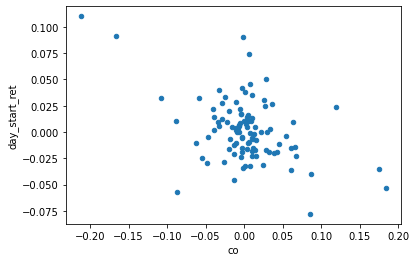

In [115]:
df = pd.DataFrame({"co": co_ret, "day_start_ret": day_start_rets}).dropna()
df.plot.scatter('co', 'day_start_ret')
print(scipy.stats.spearmanr(df.values[:, 0], df.values[:, 1]))

In [116]:
df['st_ret'] = 0
df.loc[df['co']>0, 'st_ret'] = -df['day_start_ret']
df.loc[df['co']<0, 'st_ret'] = df['day_start_ret']
np.exp(df['st_ret'].sum()) - 1

0.7307966690808834

<AxesSubplot:xlabel='start_time'>

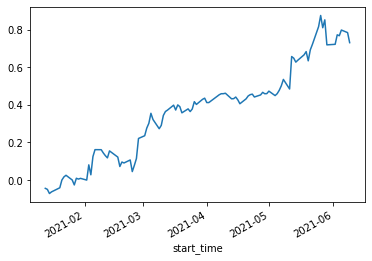

In [120]:
df['st_ret'].cumsum().apply(np.expm1).plot()

In [178]:
# 为什么使用重叠数据得到的样本数据能够发现显著的相关性，但是使用非重叠的数据得到的样本数据确没有显著的相关性。



,ret,next_ret
visible_time,,


In [356]:
P = 10
def calc(df: DataFrame):
    if len(df) <= 0:
        return None
    ret = np.log(df['close'] / df['close'].shift(P))
    next_ret = ret.shift(-P)
    df = pd.DataFrame({"ret": ret, 'next_ret': next_ret}).dropna()
    import random
    # 下面的选择算法中，如果按照固定的间隔选取，或者随机选出，都不具有显著的负相关性
    # 但是如果按块进行选取的话，则具有非常显著的负相关性
    # 这似乎也佐证了这个序列有非常强的自相关性（这是因为使用了重叠的数据来计算）
    # 那这个数据有什么意义呢， 说明在任意的时间块内，如果某个时间区间P内的涨幅相对于
    # 这个时间块内其他的相同间隔的时间区间的涨幅教高，那么相邻的时间区间P'的跌幅相对于
    # 其他时间区间的跌幅也较高
    # 基于这个现象，是否可以动态计算最近的一个时间快内某个间隔的时间区间的回报分布，若
    # 下一个时间区间的涨幅大于这个分布的75%分位数则做空，若小于这个分布的25%分位数
    # 则做多。 实践发现这个策略也没法建立优势，因为序列的强相关性，所以一个时间块
    # 内，计算相关性的两个变量并不是近似服从均值为0的正态分布，这就可能出现虽然它们
    # 之间存在负相关性，但是未来回报和过去回报都是正的。所以由相关性转化成策略其实暗含了
    # 回报服从均值为0的正态分布的假设。
    # df = df.iloc[[ random.randint(0, 369) for i in range(37)]] # 随机选取
    # df = df.iloc[random.randint(0, 9)::P] # 固定间隔选取
    start_idx = random.randint(0, 330)
    df = df.iloc[start_idx: start_idx+37: 1] # 块选取
    r, p = scipy.stats.spearmanr(df.values[:, 0], df.values[:, 1])
    df['st_ret'] = 0
    df.loc[df['ret']>0, 'st_ret'] = -df['next_ret']
    df.loc[df['ret']<0, 'st_ret'] = df['next_ret']

    return pd.Series({'r': r, 'p': p, 'st_ret': df['st_ret'].sum()})

res = MIN_BAR_DF.groupby(pd.Grouper(freq='1D', origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).apply(calc).dropna()
from prop import min_happen_prop
print("显著正相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]>0)]),len(res)))
print("显著负相关数：{}/{}".format(len(res[(res['p']<0.05) & (res["r"]<0)]), len(res)))
print(min_happen_prop(len(res), len(res[(res['p']<0.05) & (res["r"]<0)]), 0.05))
print("策略日平均回报:{}".format(res['st_ret'].mean()))

ERROR:ibapi.wrapper:ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
ERROR:root:ib client error, req_id:-1, errorCode:502, errorString:Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
ERROR:root:Traceback (most recent call last):
  File "/Users/zhang/PycharmProjects/stratege_engine/se2/infras/ib2.py", line 204, in ping
    time.sleep(10)
  File "/Users/zhang/PycharmProjects/

In [354]:
res


,r,p,st_ret
visible_time,,,
2021-01-11 21:00:00+08:00,-0.514167,1.132468e-03,-0.012206
2021-01-12 21:00:00+08:00,-0.289474,8.224809e-02,0.067919
2021-01-13 21:00:00+08:00,-0.114746,4.988772e-01,-0.030082
2021-01-14 21:00:00+08:00,-0.435989,6.987593e-03,-0.197631
2021-01-15 21:00:00+08:00,-0.767589,2.968115e-08,-0.037038
...,...,...,...
2021-06-02 21:00:00+08:00,-0.347718,3.496234e-02,0.007039
2021-06-03 21:00:00+08:00,0.165264,3.283214e-01,-0.220078
2021-06-04 21:00:00+08:00,-0.252638,1.314051e-01,0.060778


In [186]:
df = MIN_BAR_DF.loc['2021-02-01 21:00:00':'2021-02-02 21:00:00']
ret = np.log(df['close'] / df['close'].shift(P))
next_ret = ret.shift(-P)
df = pd.DataFrame({"ret": ret, 'next_ret': next_ret}).dropna()
df.head()
print(scipy.stats.spearmanr(df.values[:, 0], df.values[:, 1]))
for i in range(P):
    print(">>>>"+str(i))
    sdf = df.iloc[i::P]
    print(scipy.stats.spearmanr(sdf.values[:, 0], sdf.values[:, 1]))


SpearmanrResult(correlation=-0.1744725011679553, pvalue=0.000750106817792731)
>>>>0
SpearmanrResult(correlation=-0.23968705547652916, pvalue=0.15304923956427657)
>>>>1
SpearmanrResult(correlation=-0.25177809388335703, pvalue=0.13276746228807448)
>>>>2
SpearmanrResult(correlation=-0.23091512565196773, pvalue=0.16911316424178716)
>>>>3
SpearmanrResult(correlation=-0.19701280227596016, pvalue=0.24250490465168362)
>>>>4
SpearmanrResult(correlation=-0.14058795637743005, pvalue=0.4065696450288516)
>>>>5
SpearmanrResult(correlation=0.1853959222380275, pvalue=0.2719552497667867)
>>>>6
SpearmanrResult(correlation=0.0910384068278805, pvalue=0.592046090895457)
>>>>7
SpearmanrResult(correlation=-0.08036984352773825, pvalue=0.636314781295953)
>>>>8
SpearmanrResult(correlation=-0.32076813655761016, pvalue=0.052906559011768155)
>>>>9
SpearmanrResult(correlation=-0.3942626837363679, pvalue=0.015752098336190058)


In [194]:
df['st_ret'] = 0
df.loc[df['ret']>0, 'st_ret'] = -df['next_ret']
df.loc[df['ret']<0, 'st_ret'] = df['next_ret']
np.exp(df.iloc[7::P]['st_ret'].sum()) - 1


0.00888868667496956

In [301]:
# 下面根据上面发现的局部负相关性来构建策略,
P = 10
B = 70
quantile_up = 99
quantile_down = 1
def calc_quantile(block_ser: Series):
    """
    计算最新的回报在块内所有回报的分为数
    :param block_df:
    :return:
    """
    block_rets: Series = np.log(block_ser / block_ser.shift(P)).dropna()
    sample: Series = block_rets.iloc[:-1]
    q = scipy.stats.percentileofscore(sample, block_rets.iloc[-1])
    return q

def calc_daily_stats(daily_df: Series):
    if len(daily_df) <= 0:
        return None
    quantiles = daily_df['close'].rolling(window=B).apply(calc_quantile)
    next_ret = np.log(daily_df['close'].shift(-P) / daily_df['close'])
    df = pd.DataFrame({'quantile': quantiles, 'next_ret': next_ret})
    df = df.dropna()
    df['st_ret'] = 0
    df.loc[df['quantile']>quantile_up, 'st_ret'] = -df['next_ret']
    df.loc[df['quantile']<quantile_down, 'st_ret'] = df['next_ret']
    return df['st_ret'][df['st_ret']!=0].describe()

res = MIN_BAR_DF.loc["2021-05-09 21:00:00":].groupby(pd.Grouper(freq='1D',
                                    origin=pd.Timestamp('21:00:00', tz='Asia/Shanghai'))).apply(calc_daily_stats).dropna()
res

,count,mean,std,min,25%,50%,75%,max
visible_time,,,,,,,,
2021-05-10 21:00:00+08:00,19.0,-0.002693,0.004148,-0.010917,-0.005203,-0.002768,-5.545861e-04,0.005580
2021-05-11 21:00:00+08:00,16.0,0.005873,0.006680,-0.007439,0.004126,0.007707,9.882240e-03,0.016925
2021-05-12 21:00:00+08:00,19.0,-0.002538,0.006136,-0.013135,-0.006720,-0.001822,2.134779e-03,0.007910
2021-05-13 21:00:00+08:00,16.0,-0.003027,0.009012,-0.017482,-0.009643,-0.004160,3.980449e-03,0.010971
2021-05-14 21:00:00+08:00,14.0,-0.003216,0.004797,-0.011660,-0.006436,-0.004325,-2.841404e-07,0.006771
2021-05-17 21:00:00+08:00,13.0,-0.003688,0.003228,-0.009072,-0.006075,-0.003674,-6.099421e-04,0.001834
2021-05-18 21:00:00+08:00,18.0,-0.002714,0.006520,-0.016009,-0.007028,-0.001991,1.128191e-03,0.010854
2021-05-19 21:00:00+08:00,3.0,0.000996,0.004016,-0.003529,-0.000574,0.002381,3.258427e-03,0.004136
2021-05-20 21:00:00+08:00,16.0,0.000810,0.008619,-0.011555,-0.006795,0.000276,8.669367e-03,0.012128


In [302]:
res['mean'].mean()

0.000140256872414905